# Brain Tumor Classification

## Notice
Before procedding through this notebook please make sure you have obtained the data from Kaggle which is automated for you in the '[data_split](https://github.com/cristopher-d-delgado/brain_tumor_classification/blob/main/data_split.ipynb)' notebook within this repository. This notebook will create a merged dataset which was used to train the deep learning models within this notebook. 

Adding on, the models trained in this repository were trained on an NVIDIA Geforce RTX 3080. Since this is the case the model performances may be slightly different if you train them using a CPU or a different graphic processing unit.

# Business Understanding

Traditional diagnostic methods involve an MRI and a biopsy which can be only as effective as the expert interpretation and time consuming. The gold standard requires an expert to make the assessment and laboratory testing to determine brain tumor type and grade. 

Utilizing a machine learning algorithm such as Deep Neural Networks can not only address this issue but enhance diagnostic accuracy, reduce interpretation time, and improve patient outcomes. [Siemens Healthineers](https://www.siemens-healthineers.com/en-us) is a global company that invests in all areas of healthcare products such as medical imaging devices, point-of-care products, and digital platforms.

Siemens is looking to incorporate machine learning algorithms into there MRI portfolio. Where there MRI technology can not only provide diagnostic images for experts but also provide insightful diagnostic information in regards to cancer diagnostics. Although there are many areas in the body that can show as cancerous they are wanting to slowly incorporate all areas into their portfolio over time.

**The objective would be to develop a diagnostic tool that can create insights for diagnosing brain tumors. This model would aim to classify such tumors and provide insight in addition to classification to help aid in diagnosis and treatment. Adding on, the model should prioritize Sensitivity as capturing the most positive cases is important because misclassifying a tumor case as no tumor is far worse than incorrectly classifying a no tumor case as a tumor.**

# Data Preparation

The purpose of preparing the images for modeling is to provide stability, improved convergence, reduce overfit, and have efficient model learning. Adding on, the images do not come with labels which provides the model with knowledge in the correct classification of an image while its learning to classify images. 

The way this is addressed is by transforming the images in the following way:
1. Convert images from Grayscale to RGB.
2. Resize images on a consistent size. 
3. Normalize images on a consistent scale from 0 to 1.
4. Provide a label for model training

This whole process is facilitated in the function '**process_data**' which can be found in the [functions.py](https://github.com/cristopher-d-delgado/brain_tumor_classification/blob/main/functions.py) module.

In [1]:
import tensorflow as tf

# Condition check to see if Tensorflow detects GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os
# Commence data pre-processing using the process_data function

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Pre-process data to have a size of (128, 128) in batches of 32 images
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Test Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


Image dimensions: (128, 128, 3)


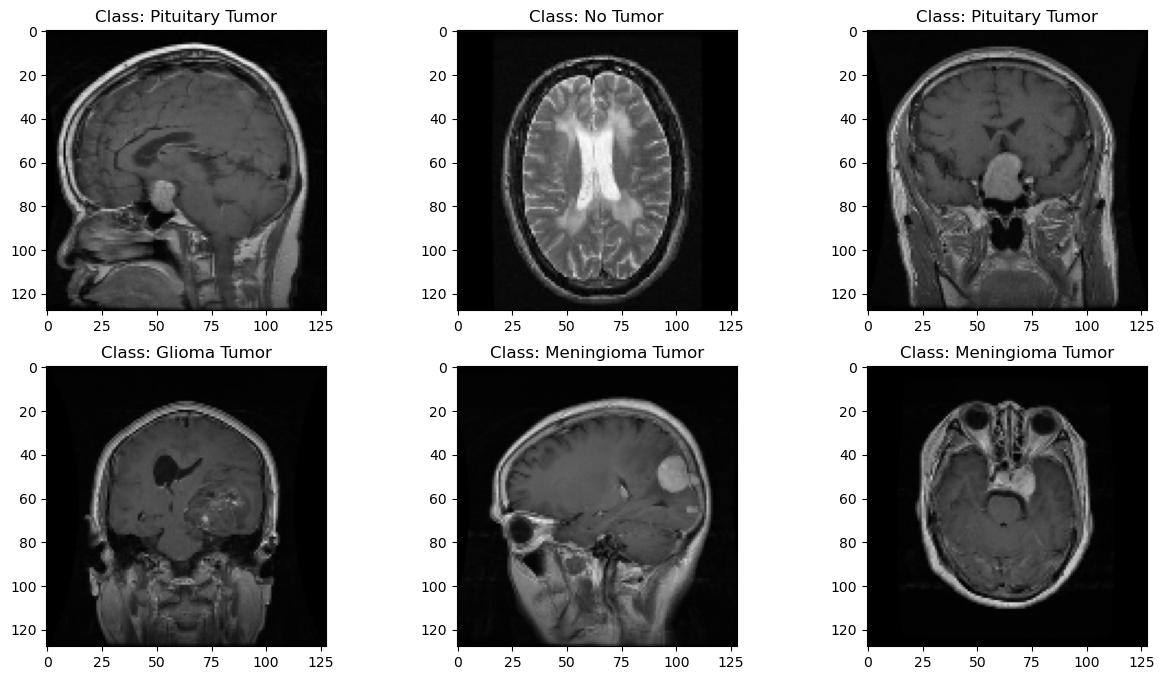

In [8]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'Glioma Tumor': 0, 'Meningioma Tumor': 1, 'No Tumor': 2, 'Pituitary Tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

# Modeling

The modeling process generally follows three main steps. 

1. Create the model architecture
2. Train the model and save training history 
3. Evaluate the model on testing data

These three steps are facilitated by three functions: 

|    Function    | Description                                                                                                       |
|:--------------:|-------------------------------------------------------------------------------------------------------------------|
|    train_model | Will train the given model architecture using image data generators. It will return the model.history attribute.  |
|   view_history | Will take the train_model functions saved history from a dictionary and graph the model history.                  |
| model_evaluate | Evaluate model on test data.                                                                                      |

## Convolutinal Base Model

To have a reference point in the modeling process, a base model must be created that just consists of one convolutional layer.

In [7]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

# Define dictionary to store history
conv = {}

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8388736   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,389,700
Trainable params: 8,389,700
Non-trainable params: 0
______________________________________________

Epoch 1/50
218/218 [==============================] - 11s 39ms/step - loss: 0.6010 - precision: 0.8313 - recall: 0.6918 - accuracy: 0.7694 - val_loss: 0.2404 - val_precision: 0.9249 - val_recall: 0.9025 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1487 - precision: 0.9508 - recall: 0.9433 - accuracy: 0.9466 - val_loss: 0.1594 - val_precision: 0.9486 - val_recall: 0.9366 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0508 - precision: 0.9869 - recall: 0.9862 - accuracy: 0.9865 - val_loss: 0.1185 - val_precision: 0.9565 - val_recall: 0.9510 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0208 - precision: 0.9951 - recall: 0.9950 - accuracy: 0.9951 - val_loss: 0.1275 - val_precision: 0.9537 - val_recall: 0.9504 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 5/50
218/218 [===========================

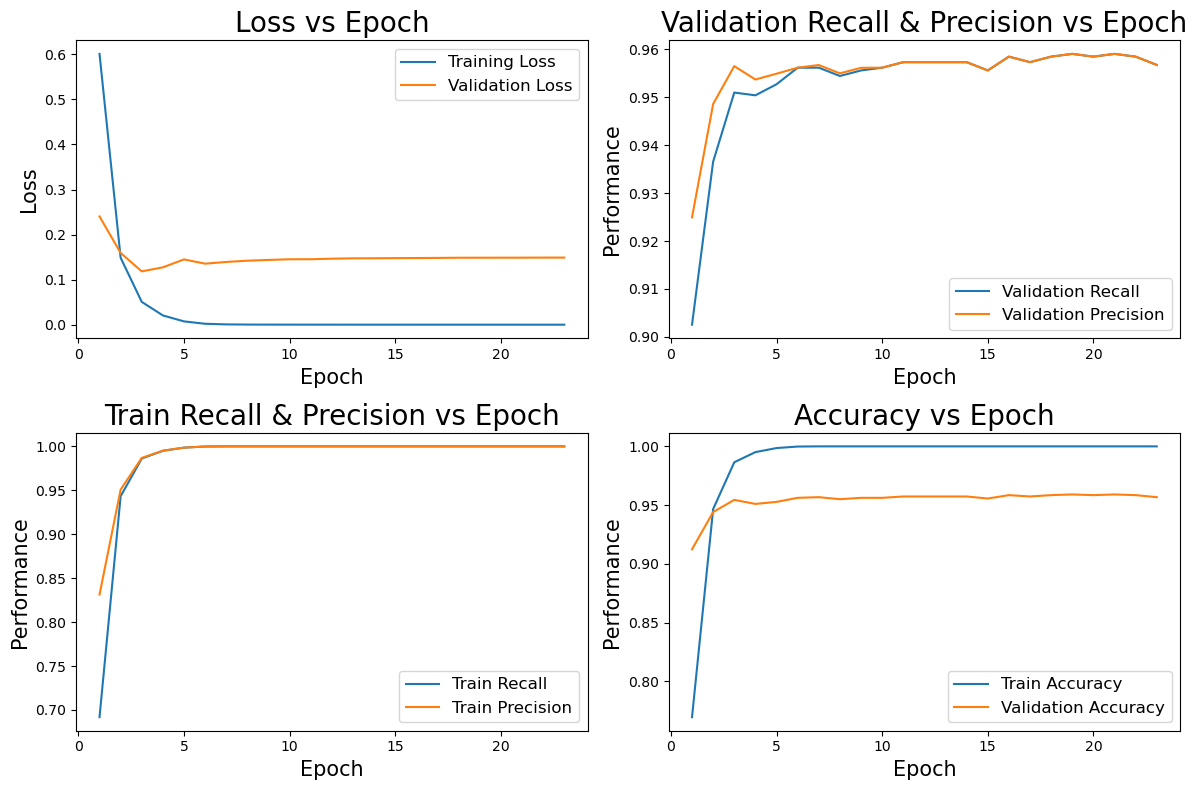

In [9]:
from functions import view_history, train_model, model_evaluate

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version1')

In [10]:
# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

 2/54 [>.............................] - ETA: 2s - loss: 0.0281 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1185 - precision: 0.9565 - recall: 0.9510 - accuracy: 0.9544


Set      Loss  Precision     Recall   Accuracy
0       Train  0.017980  99.856013  99.841636  99.856031
1        Test  0.647720  91.219801  90.791792  91.143698
2  Validation  0.118487  95.649654  95.098037  95.444059

It seems that our validation curve is just underdeveloped. Our train curve seems fine. This might be an indication of a model that is not complex enough to capture the details in the data. Lets make the model more complex

**Next Steps**: Increase model complexity to improve model learning and generalization.

## Iterative Modeling

Now that there is an established base model we can iteratively create models until we get close to overfitting. 

### CNN Version 2

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))
cnn2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(128, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 0.6224 - precision: 0.8409 - recall: 0.7271 - accuracy: 0.7498 - val_loss: 0.3719 - val_precision: 0.8723 - val_recall: 0.8466 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.2612 - precision: 0.9091 - recall: 0.8925 - accuracy: 0.9008 - val_loss: 0.2562 - val_precision: 0.9102 - val_recall: 0.8945 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1379 - precision: 0.9512 - recall: 0.9463 - accuracy: 0.9493 - val_loss: 0.2005 - val_precision: 0.9327 - val_recall: 0.9268 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0790 - precision: 0.9717 - recall: 0.9693 - accuracy: 0.9706 - val_loss: 0.1406 - val_precision: 0.9544 - val_recall: 0.9533 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 5/50
218/218 [============================

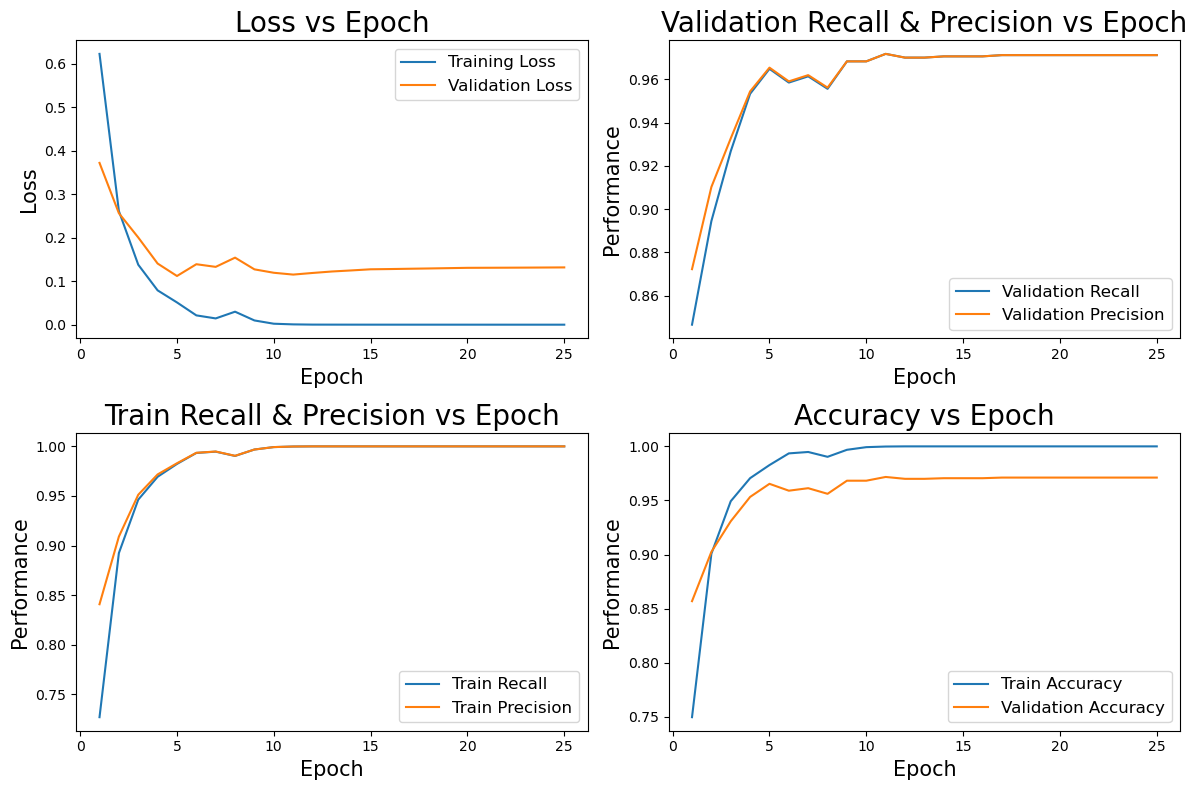

 3/54 [>.............................] - ETA: 1s - loss: 0.0121 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.1120 - precision: 0.9654 - recall: 0.9648 - accuracy: 0.9654


Set      Loss  Precision     Recall   Accuracy
0       Train  0.019821  99.553633  99.539304  99.539304
1        Test  0.939167  91.138500  91.085047  91.085047
2  Validation  0.111982  96.537799  96.482122  96.539789

In [12]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

Making the model deeper increased the generalization. Lets attempt to keep making it deeper. There is no overfit occuring yet and the model seems to do well on the train set but not the validation set. 

**Next Steps**: Make the model have a deeper architecture

### CNN Version 4

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn4 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn4.add(MaxPool2D(pool_size=(2,2)))
cnn4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn4.add(MaxPool2D(pool_size=(2,2)))
cnn4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn4.add(MaxPool2D(pool_size=(2,2)))


# Flatten Tensor
cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(Dense(128, activation='relu'))
cnn4.add(Dense(128, activation='relu'))

# Define the output 
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 0.6869 - precision: 0.8170 - recall: 0.6869 - accuracy: 0.7021 - val_loss: 0.5078 - val_precision: 0.8279 - val_recall: 0.7907 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.3898 - precision: 0.8591 - recall: 0.8321 - accuracy: 0.8465 - val_loss: 0.3167 - val_precision: 0.8891 - val_recall: 0.8691 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 38ms/step - loss: 0.2416 - precision: 0.9140 - recall: 0.9030 - accuracy: 0.9087 - val_loss: 0.3233 - val_precision: 0.8780 - val_recall: 0.8633 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1658 - precision: 0.9412 - recall: 0.9364 - accuracy: 0.9387 - val_loss: 0.1579 - val_precision: 0.9444 - val_recall: 0.9400 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 5/50
218/218 [============================

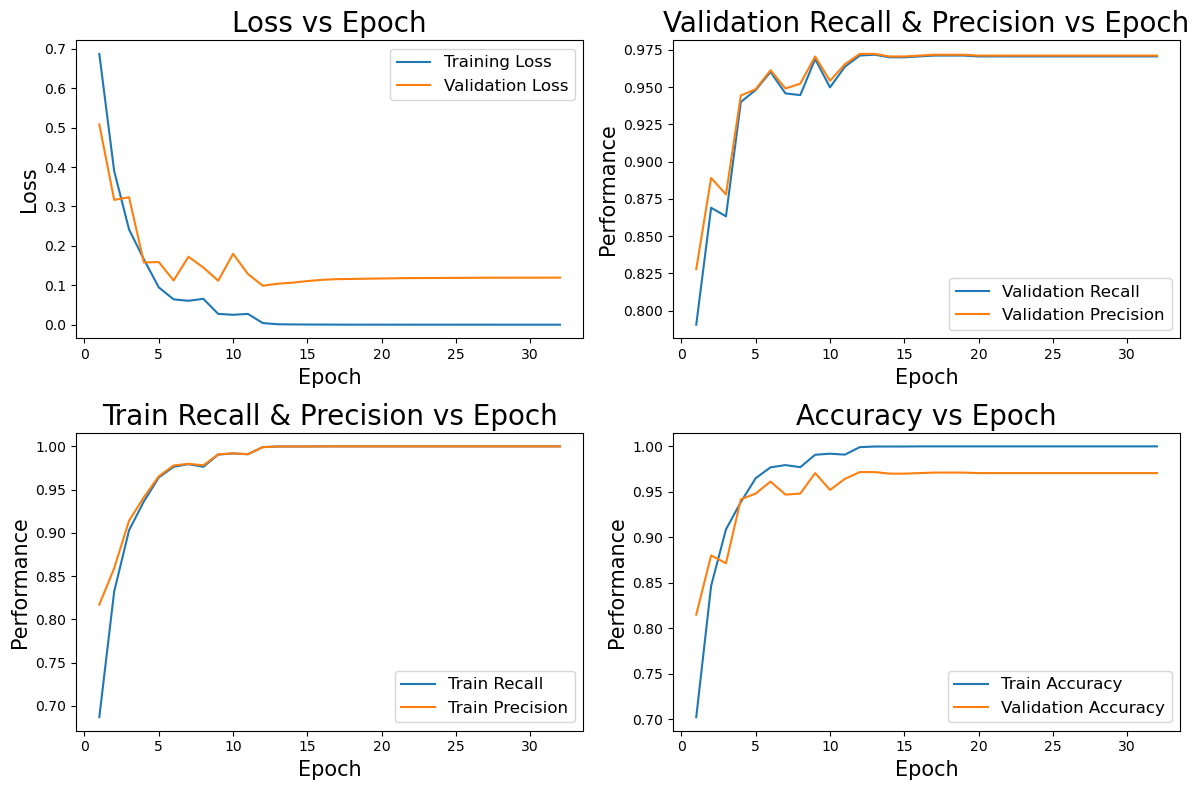

 3/54 [>.............................] - ETA: 1s - loss: 0.0012 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0990 - precision: 0.9723 - recall: 0.9712 - accuracy: 0.9717


Set      Loss  Precision     Recall   Accuracy
0       Train  0.001381  99.985605  99.985605  99.985605
1        Test  0.999695  91.197181  91.143698  91.143698
2  Validation  0.099029  97.228640  97.116494  97.174162

In [14]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version4'] = train_model(cnn4, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version4')

# Evalaute model
model_evaluate(cnn4, train_gen, test_gen, val_gen)

We are getting close to overfitting. We do see that we have some noise in the training curve now and that is also reflected in the validation curve. Just to make sure we cant add more layers lets make a model with one more layer of convolutional and dense layer.

**Next Steps**: increase model depth/complexity

### CNN Version 5

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn5 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))
cnn5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn5.add(MaxPool2D(pool_size=(2,2)))
cnn5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn5.add(MaxPool2D(pool_size=(2,2)))
cnn5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn5.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn5.add(Flatten())
cnn5.add(Dense(128, activation='relu'))
cnn5.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn5.add(Dense(128, activation='relu'))
cnn5.add(Dense(128, activation='relu'))

# Define the output 
cnn5.add(Dense(4, activation='softmax'))

cnn5.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

Epoch 1/50
218/218 [==============================] - 11s 38ms/step - loss: 1.2204 - precision: 0.7364 - recall: 0.5285 - accuracy: 0.6522 - val_loss: 0.6845 - val_precision: 0.8102 - val_recall: 0.7509 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.6158 - precision: 0.8192 - recall: 0.7744 - accuracy: 0.7969 - val_loss: 0.5638 - val_precision: 0.8100 - val_recall: 0.7768 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 36ms/step - loss: 0.4707 - precision: 0.8498 - recall: 0.8234 - accuracy: 0.8380 - val_loss: 0.3833 - val_precision: 0.8895 - val_recall: 0.8633 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.3237 - precision: 0.9033 - recall: 0.8919 - accuracy: 0.8994 - val_loss: 0.3172 - val_precision: 0.9126 - val_recall: 0.9031 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 5/50
218/218 [===========================

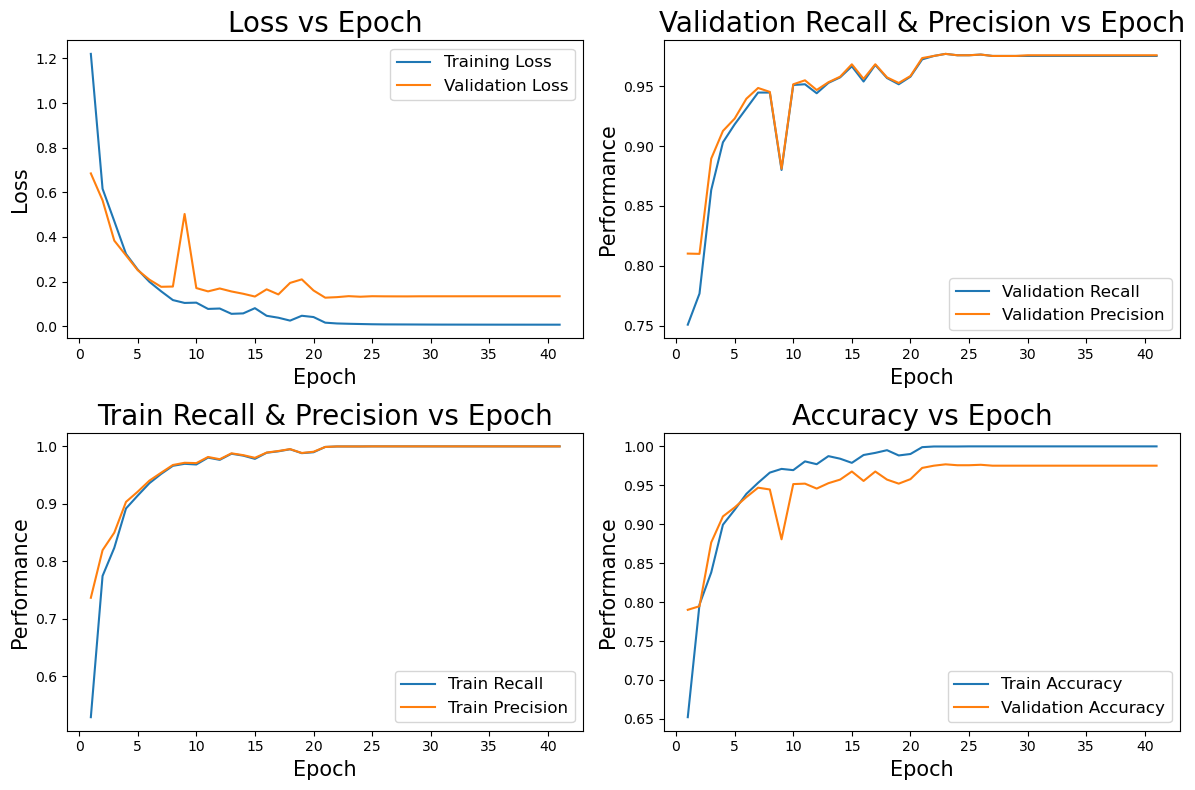

 3/54 [>.............................] - ETA: 1s - loss: 0.0114 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1275 - precision: 0.9734 - recall: 0.9723 - accuracy: 0.9723


Set      Loss  Precision     Recall   Accuracy
0       Train  0.012328  99.971205  99.971205  99.971205
1        Test  0.720142  91.436952  91.436952  91.436952
2  Validation  0.127502  97.344112  97.231835  97.231835

In [9]:
from functions import train_model, model_evaluate, view_history
conv = {}
# Train model
conv['Version5'] = train_model(cnn5, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version5')

# Evalaute model
model_evaluate(cnn5, train_gen, test_gen, val_gen)

The model is performing better than the previous model. Lets keep the model complexity the same but start adding more regularization to reduce noise on the training curve and validation curve.

**Next Steps**: Add regularization

### CNN Version 6

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn6 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Dropout(.20)) # regularization
cnn6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Dropout(.20)) # regularization

# Flatten Tensor
cnn6.add(Flatten())
cnn6.add(Dense(128, activation='relu'))
cnn6.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn6.add(Dense(128, activation='relu'))
cnn6.add(Dense(128, activation='relu'))

# Define the output 
cnn6.add(Dense(4, activation='softmax'))

cnn6.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn6.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)       

Epoch 1/50
218/218 [==============================] - 9s 39ms/step - loss: 1.2959 - precision: 0.7903 - recall: 0.5791 - accuracy: 0.6274 - val_loss: 0.7991 - val_precision: 0.7372 - val_recall: 0.6551 - val_accuracy: 0.7128 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.6704 - precision: 0.7986 - recall: 0.7375 - accuracy: 0.7725 - val_loss: 0.4961 - val_precision: 0.8777 - val_recall: 0.8235 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4945 - precision: 0.8509 - recall: 0.8176 - accuracy: 0.8365 - val_loss: 0.3912 - val_precision: 0.8892 - val_recall: 0.8749 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4125 - precision: 0.8686 - recall: 0.8460 - accuracy: 0.8575 - val_loss: 0.3157 - val_precision: 0.8995 - val_recall: 0.8881 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 5/50
218/218 [============================

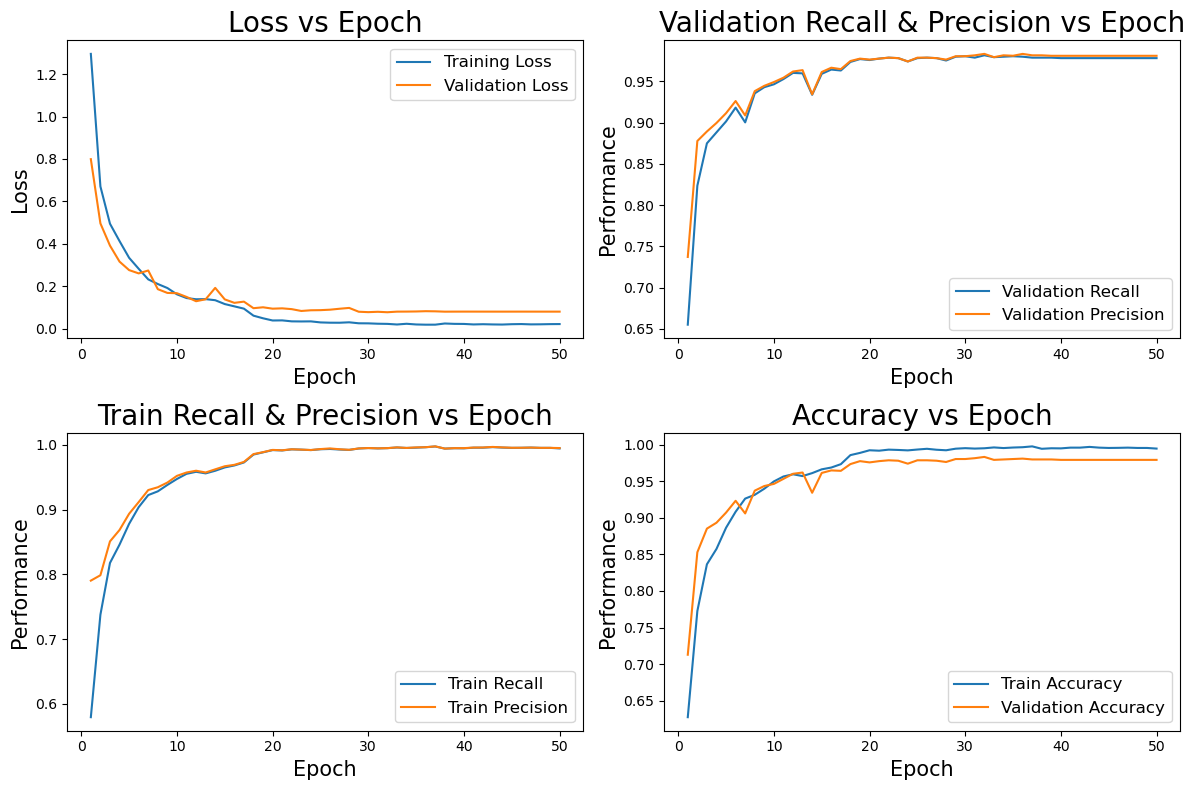

 3/54 [>.............................] - ETA: 1s - loss: 0.0140 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0773 - precision: 0.9804 - recall: 0.9804 - accuracy: 0.9804


Set      Loss  Precision     Recall   Accuracy
0       Train  0.010888  99.985605  99.985605  99.985605
1        Test  0.799056  92.366409  92.258066  92.316717
2  Validation  0.077320  98.039216  98.039216  98.039216

In [11]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version6'] = train_model(cnn6, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version6')

# Evalaute model
model_evaluate(cnn6, train_gen, test_gen, val_gen)

Adding regularization helped get rid of some of the noise in the model. There is still some noise that is present so we can increase the regularization in order to fix this issue.

**Next Steps:** Increase regularization

### CNN Version 7

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn7 = Sequential()

# Define the layers 
cnn7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn7.add(MaxPool2D(pool_size=(2,2)))
cnn7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn7.add(MaxPool2D(pool_size=(2,2)))

# Regularization
cnn7.add(Dropout(.40))

cnn7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn7.add(MaxPool2D(pool_size=(2,2)))
cnn7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))

# Regularization
cnn7.add(Dropout(.40))

# Flatten Tensor
cnn7.add(Flatten())
cnn7.add(Dense(128, activation='relu'))
cnn7.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn7.add(Dense(128, activation='relu'))
cnn7.add(Dense(128, activation='relu'))

# Define the output 
cnn7.add(Dense(4, activation='softmax'))

cnn7.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2

Epoch 1/50
218/218 [==============================] - 21s 59ms/step - loss: 1.2053 - precision: 0.7397 - recall: 0.5276 - accuracy: 0.6454 - val_loss: 0.6791 - val_precision: 0.8241 - val_recall: 0.7405 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.6403 - precision: 0.8107 - recall: 0.7518 - accuracy: 0.7861 - val_loss: 0.6107 - val_precision: 0.7945 - val_recall: 0.7468 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.5002 - precision: 0.8404 - recall: 0.8051 - accuracy: 0.8259 - val_loss: 0.4150 - val_precision: 0.8816 - val_recall: 0.8501 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4061 - precision: 0.8623 - recall: 0.8426 - accuracy: 0.8514 - val_loss: 0.4490 - val_precision: 0.8156 - val_recall: 0.8010 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 5/50
218/218 [===========================

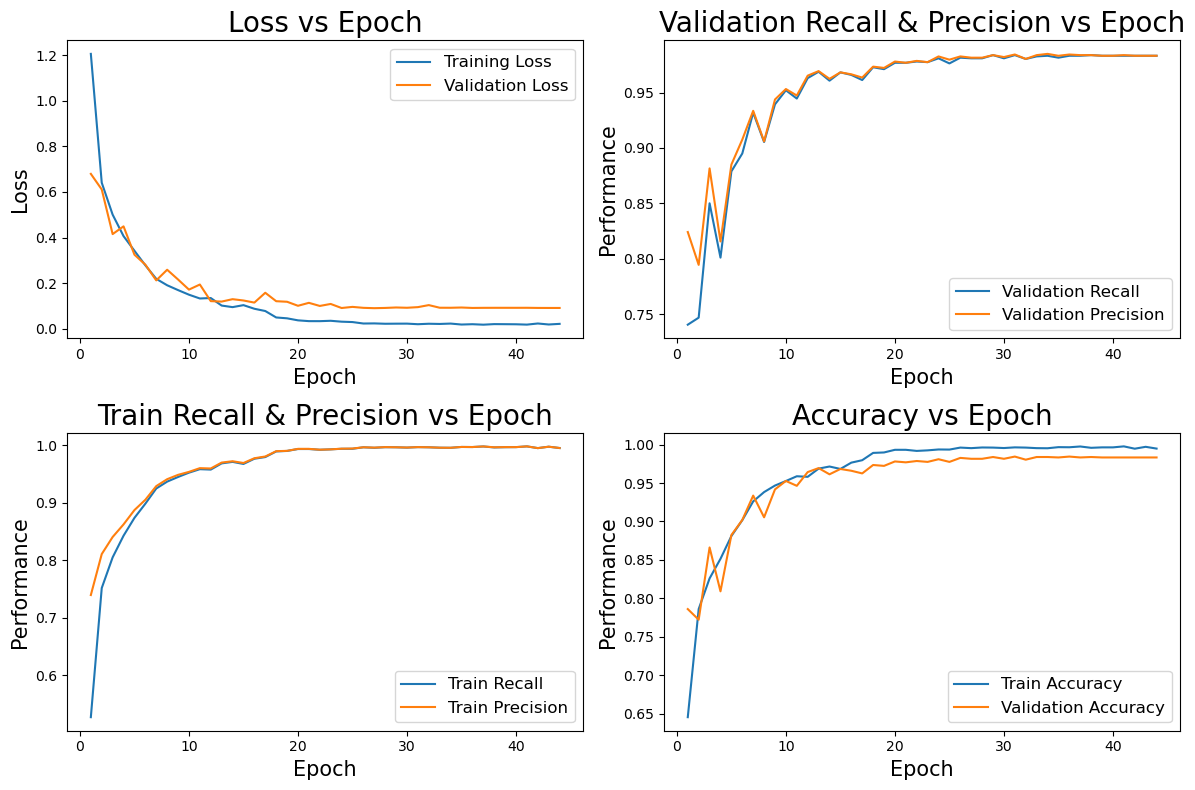

 3/54 [>.............................] - ETA: 2s - loss: 0.0118 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0909 - precision: 0.9827 - recall: 0.9810 - accuracy: 0.9810


Set      Loss  Precision     Recall   Accuracy
0       Train  0.013354  99.942410  99.942410  99.942410
1        Test  0.727941  92.018777  91.964811  91.964811
2  Validation  0.090854  98.266900  98.096883  98.096883

In [11]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version7'] = train_model(cnn7, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version7')

# Evalaute model
model_evaluate(cnn7, train_gen, test_gen, val_gen)

It seems we perform about the same as the previous iteration. Instead lets regress back to .2 and increase l2 regularization so we work with more information but its penalized later on in the architecture.

**Next Steps:** Increase l2 regularization

### CNN Version 8

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn8 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn8.add(MaxPool2D(pool_size=(2,2)))
cnn8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn8.add(MaxPool2D(pool_size=(2,2)))

# Regularization
cnn8.add(Dropout(.20))

cnn8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn8.add(MaxPool2D(pool_size=(2,2)))
cnn8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn8.add(MaxPool2D(pool_size=(2,2)))

# Regularization
cnn8.add(Dropout(.20))

# Flatten Tensor
cnn8.add(Flatten())
cnn8.add(Dense(128, activation='relu'))
cnn8.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
cnn8.add(Dense(128, activation='relu'))
cnn8.add(Dense(128, activation='relu'))

# Define the output 
cnn8.add(Dense(4, activation='softmax'))

cnn8.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn8.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)       

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 3.7145 - precision: 0.7880 - recall: 0.5665 - accuracy: 0.6107 - val_loss: 0.7515 - val_precision: 0.8159 - val_recall: 0.7082 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.6761 - precision: 0.7659 - recall: 0.6897 - accuracy: 0.7380 - val_loss: 0.5559 - val_precision: 0.8073 - val_recall: 0.7537 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.5293 - precision: 0.8183 - recall: 0.7734 - accuracy: 0.7966 - val_loss: 0.4343 - val_precision: 0.8517 - val_recall: 0.8316 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4442 - precision: 0.8495 - recall: 0.8234 - accuracy: 0.8372 - val_loss: 0.5796 - val_precision: 0.7825 - val_recall: 0.7572 - val_accuracy: 0.7699 - lr: 0.0010
Epoch 5/50
218/218 [============================

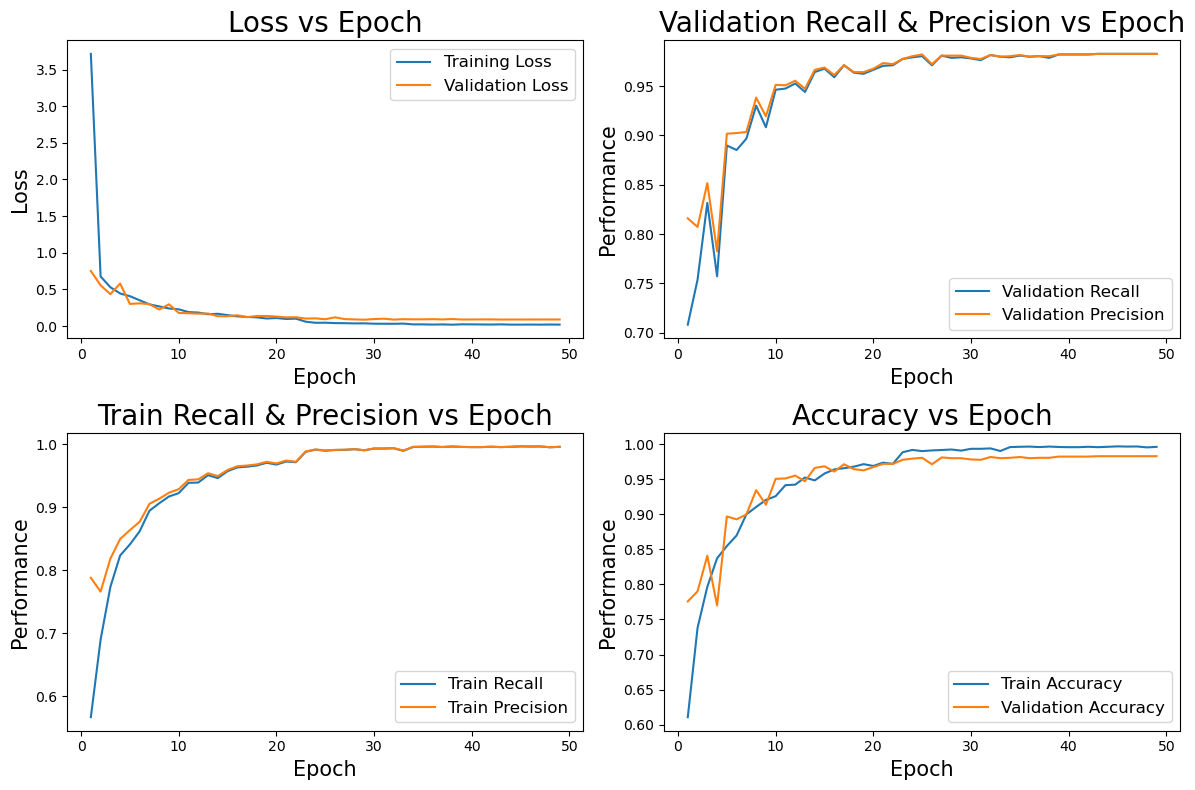

 3/54 [>.............................] - ETA: 1s - loss: 0.0177 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0857 - precision: 0.9809 - recall: 0.9792 - accuracy: 0.9798


Set      Loss  Precision     Recall   Accuracy
0       Train  0.015333  99.928015  99.928015  99.928015
1        Test  0.739216  91.495603  91.495603  91.495603
2  Validation  0.085733  98.093587  97.923875  97.981548

In [13]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version8'] = train_model(cnn8, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version8')

# Evalaute model
model_evaluate(cnn8, train_gen, test_gen, val_gen)

This seems to be our best version so far. The reason its the best is because its the only version to get below .09 loss suggesting the validation loss and train loss are closer together now. 

It seems that this framework is working well but the model learning rate overshoots in the beginning. The next step would be to do a parameter search to find the best parameters to avoid this.

**Next Steps**: Use Keras Tuner

## Hyper parameter tuning

Hyper parameter tuning will allow us to squeeze the most performance we can using the framework/architecture we have so far. It is similar to a GridSearch except, depending on the search type it can do it exhaustively, randomly, or with learning. In this case we use the Hyperband parameter search which is a type of random search that considers the most promising iterations and continue to narrow down considering the target which will be 'validation loss'. 

In other words the parameter search will find the most promising parameters that will give us the lowest validation loss.

In [9]:
import keras_tuner
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.losses import CategoricalCrossentropy
from functions import get_callbacks
from keras.regularizers import l2
from keras.metrics import Precision, Recall
import os

# Instantiate Tuner and metrics to track
hp = keras_tuner.HyperParameters()
input_shape = (128, 128, 3)
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

# Create model framework that gave the best performance from our trials above
def build_model1(hp=hp, input_shape=input_shape, metrics=metrics):
    # Instatiate model
    model = Sequential()
    
    # Make Convolutional network
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=272, step=16),
                    kernel_size=hp.Choice('kernel_size_1', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_1', values=['valid', 'same']),
                    input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=272, step=16),
                    kernel_size=hp.Choice('kernel_size_2', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_2', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_1', min_value=0, max_value=.5, step=.1)))
    model.add(Conv2D(filters=hp.Int('filters_3', min_value=16, max_value=272, step=16),
                    kernel_size=hp.Choice('kernel_size_3', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_3', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=hp.Int('filters_4', min_value=16, max_value=272, step=16),
                    kernel_size=hp.Choice('kernel_size_4', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_4', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_2', min_value=0, max_value=.5, step=.1)))

    # Flatten Tensor and create Fully conected layers
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_1', min_value=1, max_value=256, step=31), 
                    activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=1, max_value=256, step=31), 
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('regularization_factor', min_value=1e-6, max_value=1, sampling='log'))))
    model.add(Dense(units=hp.Int('units_4', min_value=1, max_value=256, step=31), 
                    activation='relu'))
    model.add(Dense(units=hp.Int('units_5', min_value=1, max_value=256, step=31), 
                    activation='relu'))
    
    # Create output layer
    model.add(Dense(units=4, activation='softmax'))
    
    # Define optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Compile model
    model.compile(optimizer=optimizer_choice,
                loss=CategoricalCrossentropy(),
                metrics=metrics)
    
    return model

# Create directory to save trail data 
tuner_directory = "trials/"

if not os.path.exists(tuner_directory):
    os.makedirs(tuner_directory)
    print(f"Directory '{tuner_directory}' created.")
else:
    print(f"Directory '{tuner_directory}' already exists.")

# Define the tuner/search strategy
tuner = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective='val_loss',
    max_epochs=60, # maximum number of epochs to train one model. Last model was 50 and converged but didnt overfit.
    directory=tuner_directory,
    project_name='my_hyperband_project1',
    seed=42
)

# Tuner.search uses same param as .fit()
# Run the hyperparameter search
tuner.search(train_gen, validation_data=val_gen, callbacks=get_callbacks())

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 90 Complete [00h 00m 00s]

Best val_loss So Far: 0.04924608767032623
Total elapsed time: 02h 47m 31s


In [10]:
# View the model
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 192)     5376      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 192)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 80)        138320    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 80)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 80)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 160)      

In [11]:
print(best_hyperparameters.values)

{'filters_1': 192, 'kernel_size_1': 3, 'padding_1': 'same', 'filters_2': 80, 'kernel_size_2': 3, 'padding_2': 'same', 'droprate_1': 0.2, 'filters_3': 160, 'kernel_size_3': 3, 'padding_3': 'valid', 'filters_4': 208, 'kernel_size_4': 3, 'padding_4': 'same', 'droprate_2': 0.1, 'units_1': 32, 'units_2': 249, 'regularization_factor': 7.939999486846715e-05, 'units_4': 249, 'units_5': 249, 'optimizer': 'adam', 'tuner/epochs': 60, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Epoch 1/100
218/218 [==============================] - 9s 39ms/step - loss: 0.8452 - precision: 0.7048 - recall: 0.3707 - accuracy: 0.6068 - val_loss: 0.5988 - val_precision: 0.7654 - val_recall: 0.7001 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 2/100
218/218 [==============================] - 8s 37ms/step - loss: 0.5159 - precision: 0.8057 - recall: 0.7545 - accuracy: 0.7842 - val_loss: 0.4382 - val_precision: 0.8233 - val_recall: 0.8085 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 3/100
218/218 [==============================] - 8s 37ms/step - loss: 0.4022 - precision: 0.8519 - recall: 0.8259 - accuracy: 0.8395 - val_loss: 0.3373 - val_precision: 0.8829 - val_recall: 0.8610 - val_accuracy: 0.8749 - lr: 0.0010
Epoch 4/100
218/218 [==============================] - 8s 37ms/step - loss: 0.3016 - precision: 0.8893 - recall: 0.8746 - accuracy: 0.8825 - val_loss: 0.2206 - val_precision: 0.9188 - val_recall: 0.9135 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 5/100
218/218 [=======================

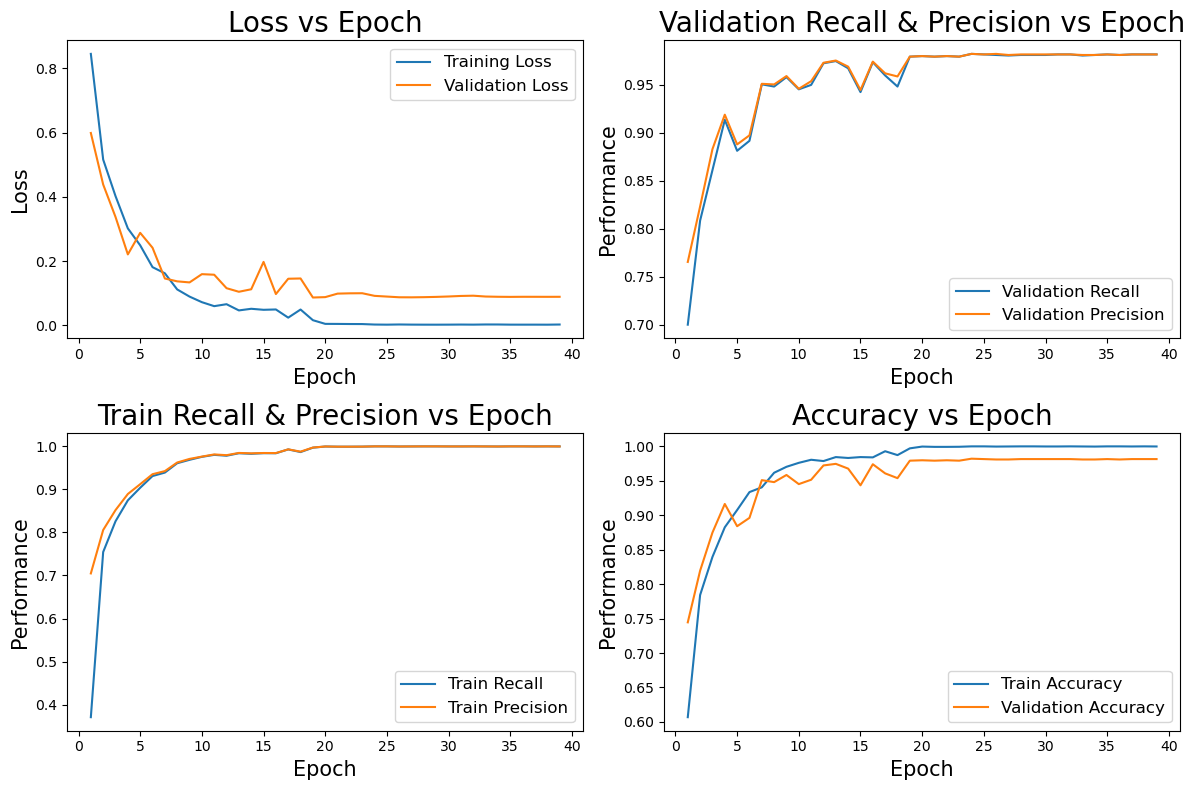

 1/54 [..............................] - ETA: 3s - loss: 0.0021 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.0863 - precision: 0.9792 - recall: 0.9792 - accuracy: 0.9792


Set      Loss   Precision      Recall    Accuracy
0       Train  0.003325  100.000000  100.000000  100.000000
1        Test  0.727310   92.983490   92.492670   92.492670
2  Validation  0.086309   97.923875   97.923875   97.923875

In [12]:
from functions import train_model, view_history, model_evaluate

# Train the model architecture from parameter search
conv = {}

conv['param1'] = train_model(best_model, train_gen, val_gen, 100)

# View history
view_history(conv, 'param1')

# Evaluate the model
model_evaluate(best_model, train_gen, test_gen, val_gen)

In [13]:
from keras.models import save_model

# Save model 
save_model(best_model, "models/op_model1.keras")

As we can see our train loss and val loss are much closer overall in this optimized version. 
This is a good thing as it allows for good generalization. 

We seem to perform about the same for testing images no matter what we do. We need to take this trained model and train it on augmented data. 

**Next Steps:** Train optimized model on augmented data.

## Data Augmentation

Data augmentation is a method to further improve deep learning models by providing synthetic data for the model to further train on. Synthetic data is made from teh original images except some transformation is created on the original image such as a rotation, image flip, or shift. 

The augmented images are provided from a function called '**data_augmentation**' which can be found in the [functions.py](https://github.com/cristopher-d-delgado/brain_tumor_classification/blob/main/functions.py) module. 

This function will perform the following steps:
1. Pre-process the images just like the original data generators
2. Create a transformed image that will be will have some transformation or transformations of the following: vertical_flip, horizontal_flip, rotation_range = 45 degrees. 

In [1]:
from functions import data_augmentation
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Obtain augmented data generators
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir=train_data_dir, test_data_dir=test_data_dir, val_data_dir=val_data_dir)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


In [15]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen_aug.class_indices
val_class_labels = train_gen_aug.class_indices
test_class_labels = val_gen_aug.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Test Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


Image dimensions: (128, 128, 3)


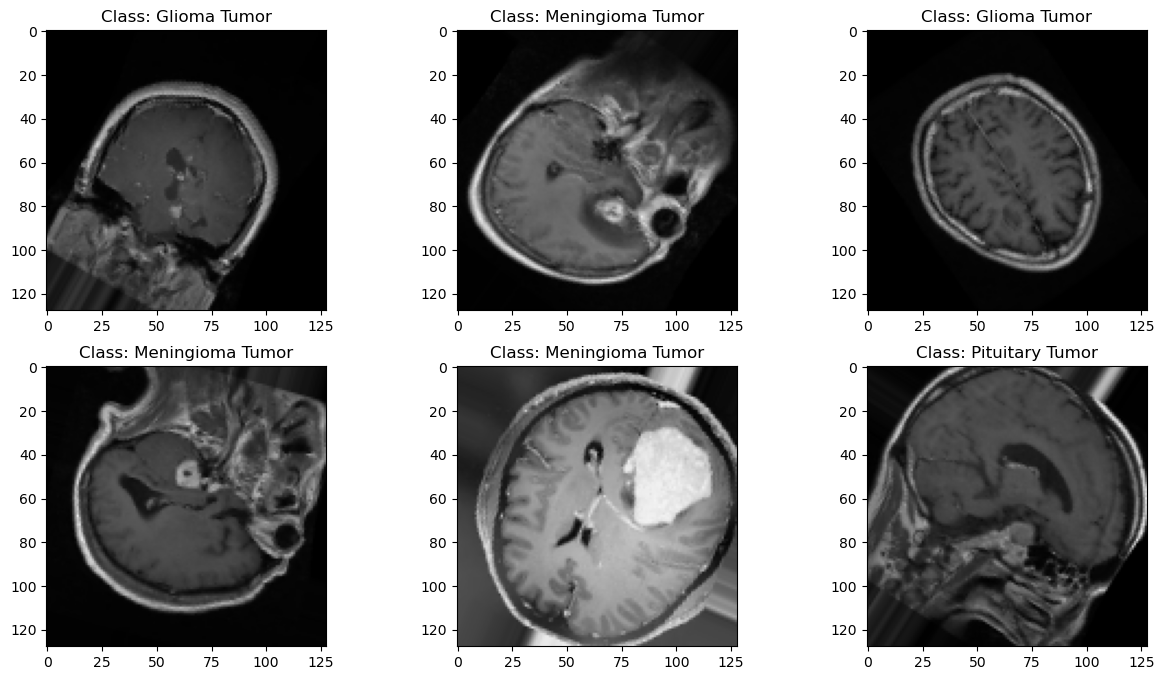

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve one batch of images from the generator
images, labels = train_gen_aug.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'Glioma Tumor': 0, 'Meningioma Tumor': 1, 'No Tumor': 2, 'Pituitary Tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

### Perform Training on Augmented Data

Epoch 1/100
218/218 [==============================] - 27s 123ms/step - loss: 1.4426 - precision: 0.6940 - recall: 0.6720 - accuracy: 0.6818 - val_loss: 1.3465 - val_precision: 0.6979 - val_recall: 0.6782 - val_accuracy: 0.6920 - lr: 3.2000e-07
Epoch 2/100
218/218 [==============================] - 25s 117ms/step - loss: 1.3879 - precision: 0.6972 - recall: 0.6738 - accuracy: 0.6847 - val_loss: 1.3272 - val_precision: 0.6978 - val_recall: 0.6713 - val_accuracy: 0.6811 - lr: 3.2000e-07
Epoch 3/100
218/218 [==============================] - 25s 116ms/step - loss: 1.3836 - precision: 0.6975 - recall: 0.6728 - accuracy: 0.6849 - val_loss: 1.3098 - val_precision: 0.6996 - val_recall: 0.6730 - val_accuracy: 0.6897 - lr: 3.2000e-07
Epoch 4/100
218/218 [==============================] - 25s 115ms/step - loss: 1.3034 - precision: 0.7053 - recall: 0.6811 - accuracy: 0.6916 - val_loss: 1.2251 - val_precision: 0.7138 - val_recall: 0.6874 - val_accuracy: 0.6995 - lr: 3.2000e-07
Epoch 5/100
218/218 

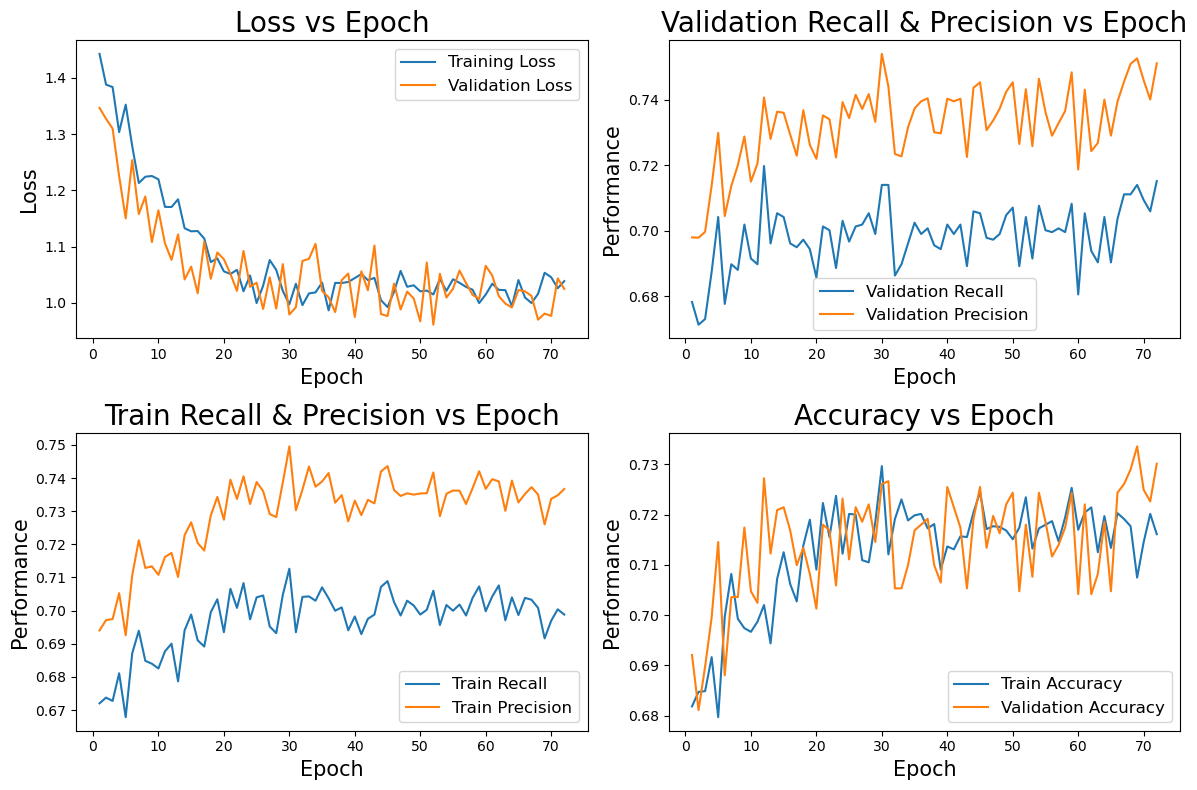

 3/54 [>.............................] - ETA: 1s - loss: 0.0039 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 5s 94ms/step - loss: 1.0315 - precision: 0.7283 - recall: 0.6972 - accuracy: 0.7116


Set      Loss  Precision     Recall   Accuracy
0       Train  0.952348  74.871564  71.336019  72.991651
1        Test  0.583753  93.140155  92.375368  92.375368
2  Validation  1.031523  72.831327  69.723183  71.164936

In [17]:
from keras.models import load_model
from functions import train_model, model_evaluate, view_history

# Load the model 
model1 = load_model("models/op_model1.keras")

# Apply data augmentation on saved model
aug = {}

# Train the model and save history
aug["Version1"] = train_model(model1, train_generator=train_gen_aug, val_gen=val_gen_aug, total_epochs=100)

# View the History
view_history(aug, "Version1")

# Evaluate model
model_evaluate(model1, train_gen=train_gen_aug, test_gen=test_gen_aug, val_gen=val_gen_aug)

In [18]:
from functions import model_evaluate, process_data

train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir=train_data_dir, test_data_dir=test_data_dir, val_data_dir=val_data_dir)

# Evaluate model on original data
model_evaluate(model1, train_gen=train_gen, test_gen=test_gen, val_gen=val_gen)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.
 3/54 [>.............................] - ETA: 1s - loss: 0.0039 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.0815 - precision: 0.9798 - recall: 0.9792 - accuracy: 0.9792


Set      Loss  Precision     Recall   Accuracy
0       Train  0.006728  99.971199  99.942410  99.971205
1        Test  0.583753  93.140155  92.375368  92.375368
2  Validation  0.081486  97.980380  97.923875  97.923875

In [19]:
from keras.models import save_model

#save_model(model1, "models/op_model1_aug.keras")

It seems that the model did learn a bit more with augmented data. This is shown by the lower validation loss on the test set and validation set in comparison to previous iterations. 

It did not have a huge performance increase but now we generalize slightly better since we had more data to train on. 

Lets view a confusion matrix on the test set. 

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np 

# Load our model 
model1 = load_model("models/op_model1_aug.keras")

# Get the number of samples in the test set
num_samples = len(test_gen)

# Initialize empty arrays to collect true labels
true_labels_all = []
predicted_labels_all = []

# Iterate over all batches in the test set
for i in range(num_samples):
    # Generate the next batch
    images, labels = test_gen.next()
    
    # Get true labels (assuming labels are one-hot encoded)
    true_labels = np.argmax(labels, axis=1)
    
    # Get predictions and labels from test set
    predictions = model1.predict(images)

    # Get the predicted labels
    predicted_labels = predictions.argmax(axis=1)
    
    # Append true and predicted labels to the lists
    true_labels_all.extend(true_labels)
    predicted_labels_all.extend(predicted_labels)


# Convert lists to numpy arrays for confusion matrix calculation
true_labels_all = np.array(true_labels_all)
predicted_labels_all = np.array(predicted_labels_all)

1/1 [==============================] - 0s 14ms/step


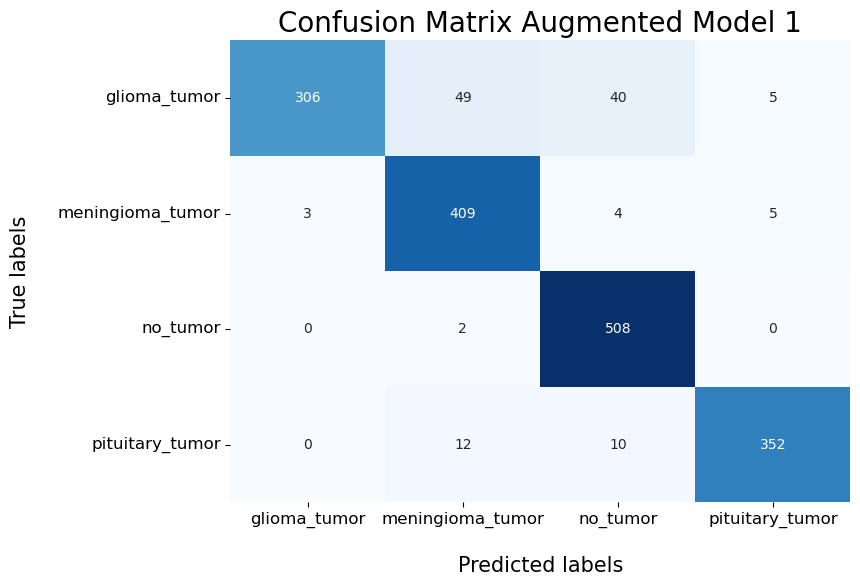

In [31]:
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_true=true_labels_all, y_pred=predicted_labels_all)

# Visualize confusion matrix 
title = 20
label = 15
ticks = 12

plt.figure(figsize=(8, 6), facecolor='white')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], 
            yticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], 
            annot_kws={"fontsize": 10}, 
            cbar=False)
plt.xlabel('Predicted labels', labelpad=20, fontsize=label)
plt.xticks(fontsize=ticks)
plt.ylabel('True labels', labelpad=20, fontsize=label)
plt.yticks(fontsize=ticks)
plt.title('Confusion Matrix Augmented Model 1', fontsize=title)
plt.show()

In [12]:
from functions import process_data
import os
### Lets view an image explainer to see how the models are evealuated

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Lets retrieve a batch of images to explain
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir=train_data_dir, test_data_dir=test_data_dir, val_data_dir=val_data_dir)
image_batch, label_batch = test_gen.next()

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


## Understanding Model Decisions

To help understand the model decision we will be using the library Lime.

Before we use Lime to explain instances we need to preprocess the data in a way LIME can easily use the images. Generators can be tricky with lime so instead we will have to manually pre-process the data instead of having generators. 

Adding on, we also have to define some functions so LIME can use in the image explainer. 

In [2]:
from PIL import Image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Preprocess data into array 
def preprocess_image(image_path, target_size=(128, 128)):
    # Open Image
    img = Image.open(image_path)
    # Resize image 
    img = img.resize(target_size)
    # Convert to RGB
    img_rgb = img.convert('RGB')
    # Convert to array and normalize
    img_array = np.array(img_rgb) / 255.0
    return img_array

# Function to predict using deep learning model
def predict_fn(model_path, images):
    model = load_model(model_path)
    return model.predict(images)

# Function to display explanations using Matplotlib
def display_explanation(mask, image):
    from skimage.segmentation import mark_boundaries
    import matplotlib.pyplot as plt
    
    plt.imshow(mark_boundaries(image, mask))
    plt.show()

In [6]:
from lime import lime_image
from keras.models import load_model
import os
from sklearn.model_selection import train_test_split

# Load our model 
model = load_model("models/op_model1_aug.keras")

# Define image explainer 
explainer = lime_image.LimeImageExplainer(random_state=42)

# List image files for every class 
train_folder = "data/training/"

class_0 = [os.path.join(train_folder, "glioma", file) for file in os.listdir(os.path.join(train_folder, "glioma")) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
class_1 = [os.path.join(train_folder, "meningioma", file) for file in os.listdir(os.path.join(train_folder, "meningioma")) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
class_2 = [os.path.join(train_folder, "no_tumor", file) for file in os.listdir(os.path.join(train_folder, "no_tumor")) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
class_3 = [os.path.join(train_folder, "pituitary", file) for file in os.listdir(os.path.join(train_folder, "pituitary")) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Preprocess images for every class
glioma = [preprocess_image(path) for path in class_0]
meningioma = [preprocess_image(path) for path in class_1]
no_tumor = [preprocess_image(path) for path in class_2]
pituitary = [preprocess_image(path) for path in class_3]

# Create labels for every class 
labels_glioma = np.zeros(len(glioma))
labels_meningioma = np.ones(len(meningioma))
labels_no_tumor = 2 * np.ones(len(no_tumor))
labels_pituitary = 3 * np.ones(len(pituitary))

# Combine all images and labels 
all_images = np.vstack([glioma, meningioma, no_tumor, pituitary])
all_labels = np.concatenate([labels_glioma, labels_meningioma, labels_no_tumor, labels_pituitary])

# Split data into training and test sets to fit the lime explainer 
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


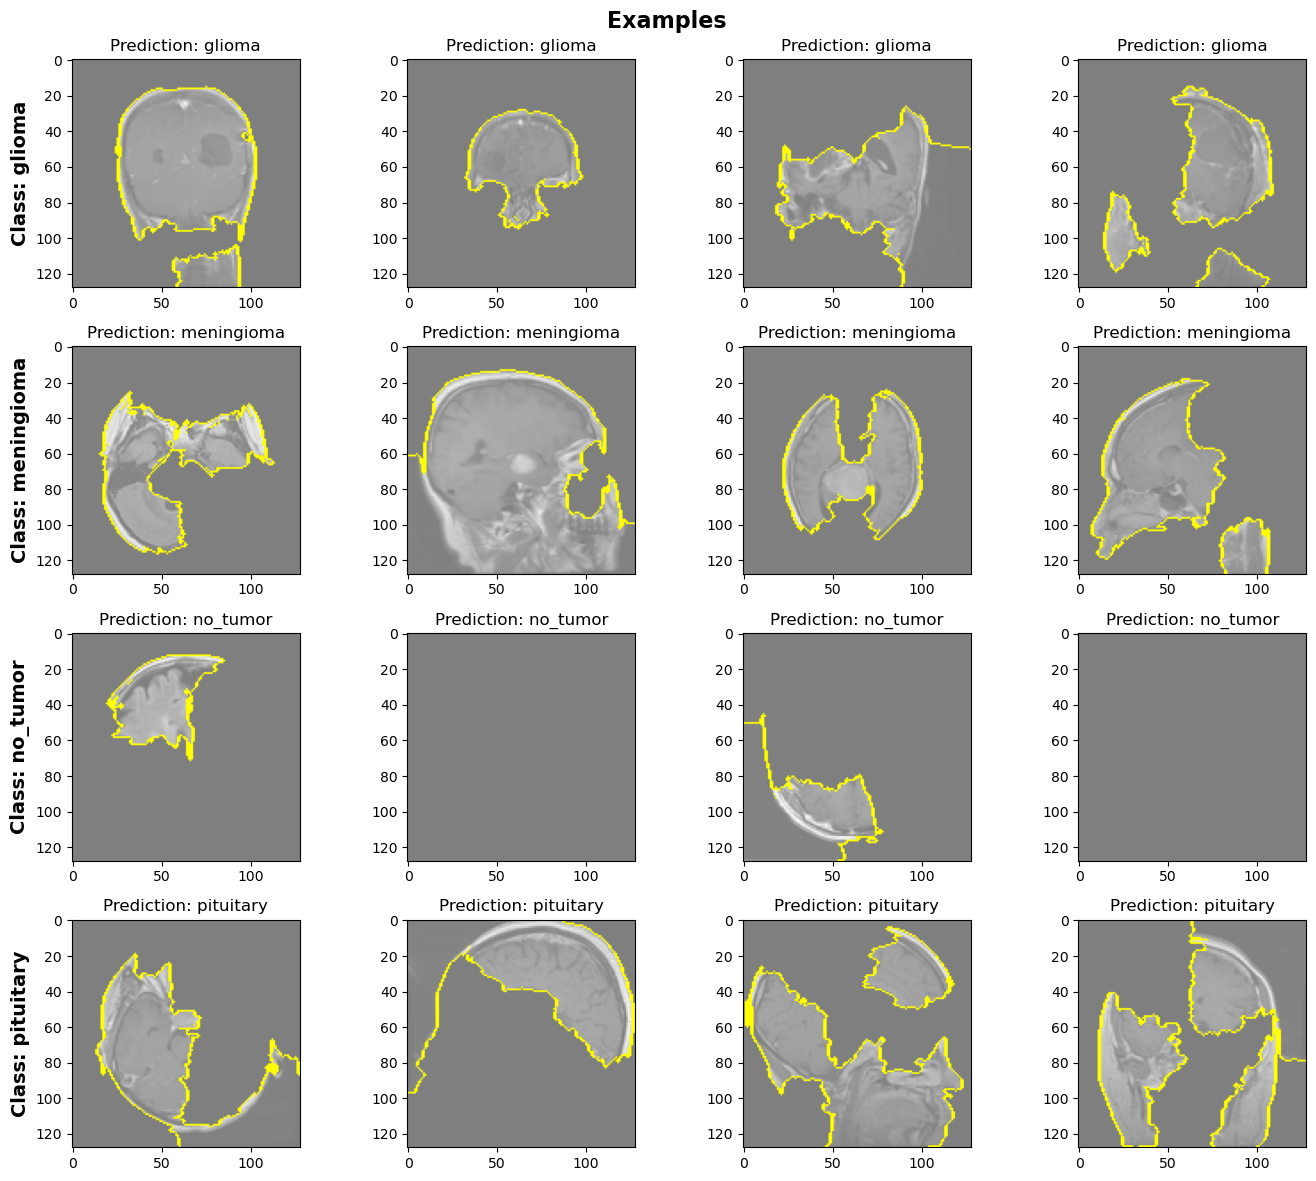

In [29]:
import matplotlib.pyplot as plt

# Select 4 instances of each class for explanation
instances_per_class = 4
instances_to_explain = []
for i in range(4):
    instances_to_explain.extend(np.where(y_test == i)[0][:instances_per_class])

# Create a single figure with multiple subplots
fig, axes = plt.subplots(4, instances_per_class, figsize=(14, 12), facecolor='white')

# Iterate over instances to explain and generate explanations
for i, instance_idx in enumerate(instances_to_explain):
    # Get image and label
    image = X_test[instance_idx]
    label = y_test[instance_idx]
    
    # Develop local model explanation
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=model.predict,
        top_labels=4,
        num_samples=2000,
        hide_color=0,
        random_seed=42
    )
    
    # Get the class name
    class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][int(label)]
    prediction = model.predict(image.reshape(1, 128, 128, 3))
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    predicted_class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][predicted_class]
    
    # Display the explanation on a subplot
    ax = axes[int(label), i % instances_per_class]
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Using the top predicted label for visualization
        positive_only=True,
        num_features=5, 
        hide_rest=True, 
        min_weight=0.1
    )
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax.set_title(f'Prediction: {predicted_class_name}')
    
    # Add superior title for each row indicating the class name
    if i % instances_per_class == 0:
        ax_row = axes[int(label), i % instances_per_class]
        ax_row.set_ylabel(f'Class: {class_name}', loc='center', fontsize=14, fontweight='bold')

# Adjust layout and show the figure
fig.suptitle('Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The following plot above is a image segmentation of the most concerning areas. In LIME it uses probability similar to the output of the deep model. 

The following images are segmented on probabilities higher than .1. The areas of the images that do show can be understood as areas that most likely would have the brain tumor. 

Of course, the segmentation may not be so useful without knowing the difference in areas that are .2 or .3 probability of concerning areas. To combat this issue we can also attempt a heatmap of the image that will show us more in depth diagnostics.

**Next Steps:** Create heatmap version of segmentation

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


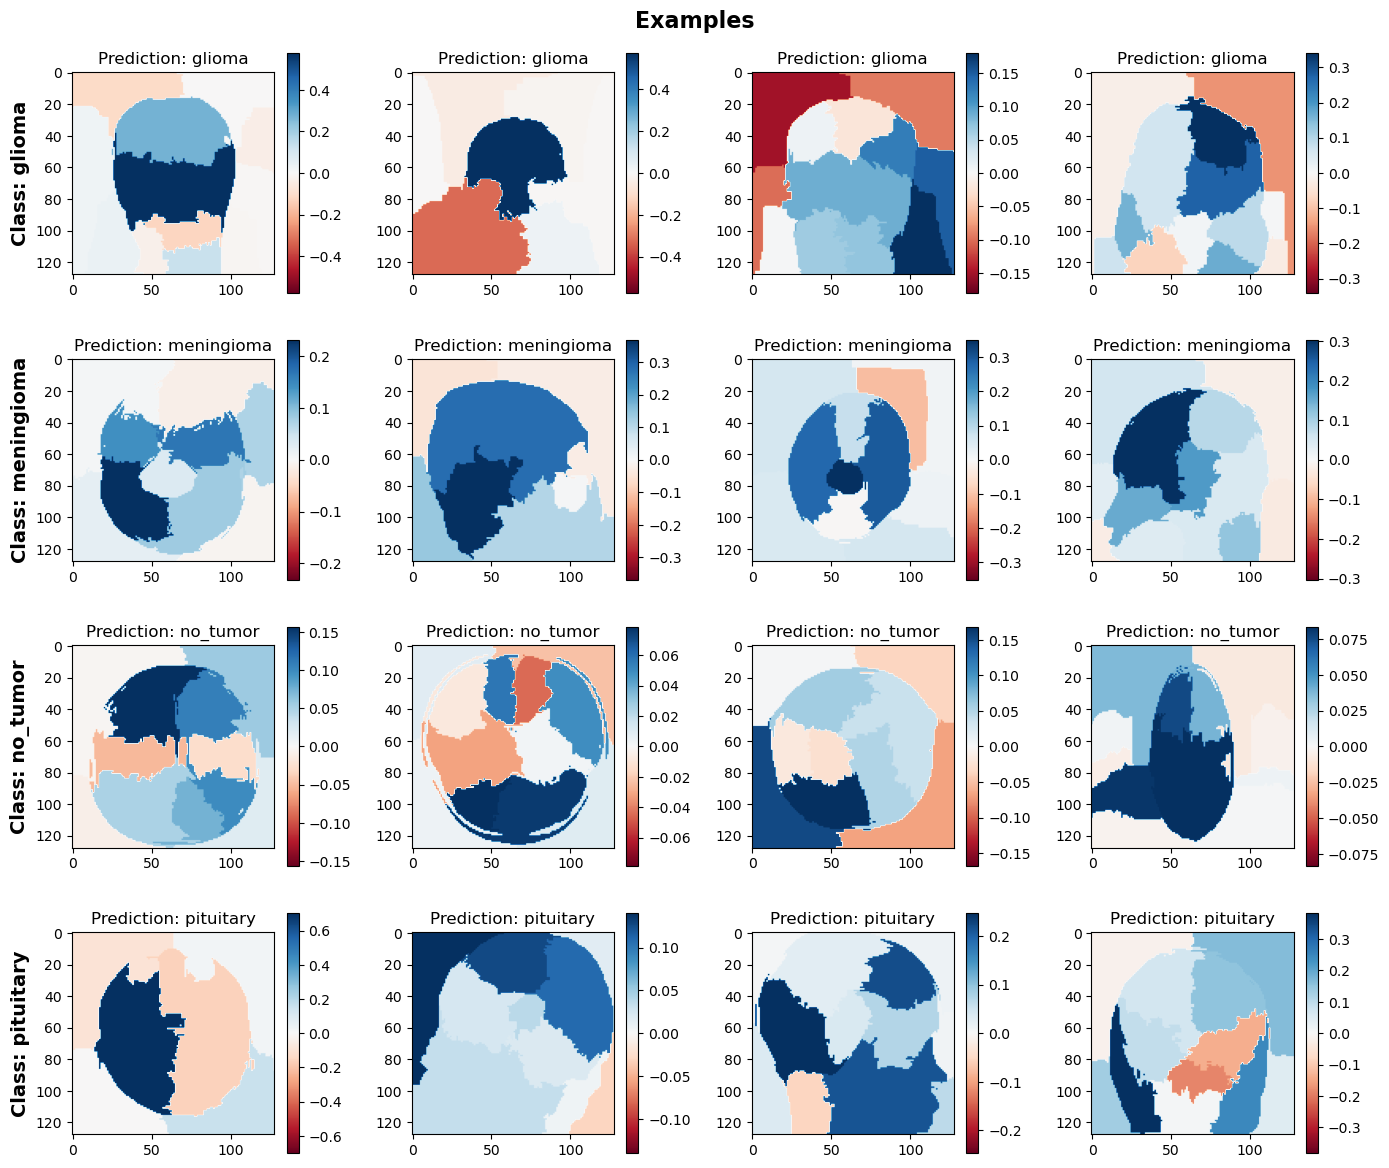

In [28]:
import matplotlib.pyplot as plt

# Select 4 instances of each class for explanation
instances_per_class = 4
instances_to_explain = []
for i in range(4):
    instances_to_explain.extend(np.where(y_test == i)[0][:instances_per_class])

# Create a single figure with multiple subplots
fig, axes = plt.subplots(4, instances_per_class, figsize=(14, 12), facecolor='white')

# Iterate over instances to explain and generate explanations
for i, instance_idx in enumerate(instances_to_explain):
    # Get image and label
    image = X_test[instance_idx]
    label = y_test[instance_idx]
    
    # Develop local model explanation
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=model.predict,
        top_labels=4,
        num_samples=2000,
        hide_color=0,
        random_seed=42
    )
    
    # Get the class name
    class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][int(label)]
    prediction = model.predict(image.reshape(1, 128, 128, 3))
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    predicted_class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][predicted_class]
    
    # Display heatmap explanation on a subplot
    ax = axes[int(label), i % instances_per_class]

    # Select the top label
    ind = explanation.top_labels[0]
    
    # Map each explanation weight to the corressponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    
    # Plot heatmap
    im = ax.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Prediction: {predicted_class_name}')
    
    # Add superior title for each row indicating the class name
    if i % instances_per_class == 0:
        ax_row = axes[int(label), i % instances_per_class]
        ax_row.set_ylabel(f'Class: {class_name}', loc='center', fontsize=14, fontweight='bold')

# Adjust layout and show the figure
fig.suptitle('Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Using the heatmap now we can see which areas are more likely to have tumors. 

The blue would be areas that are more concerning and the red would be areas that are less concerning.

1/1 [==============================] - 0s 14ms/step


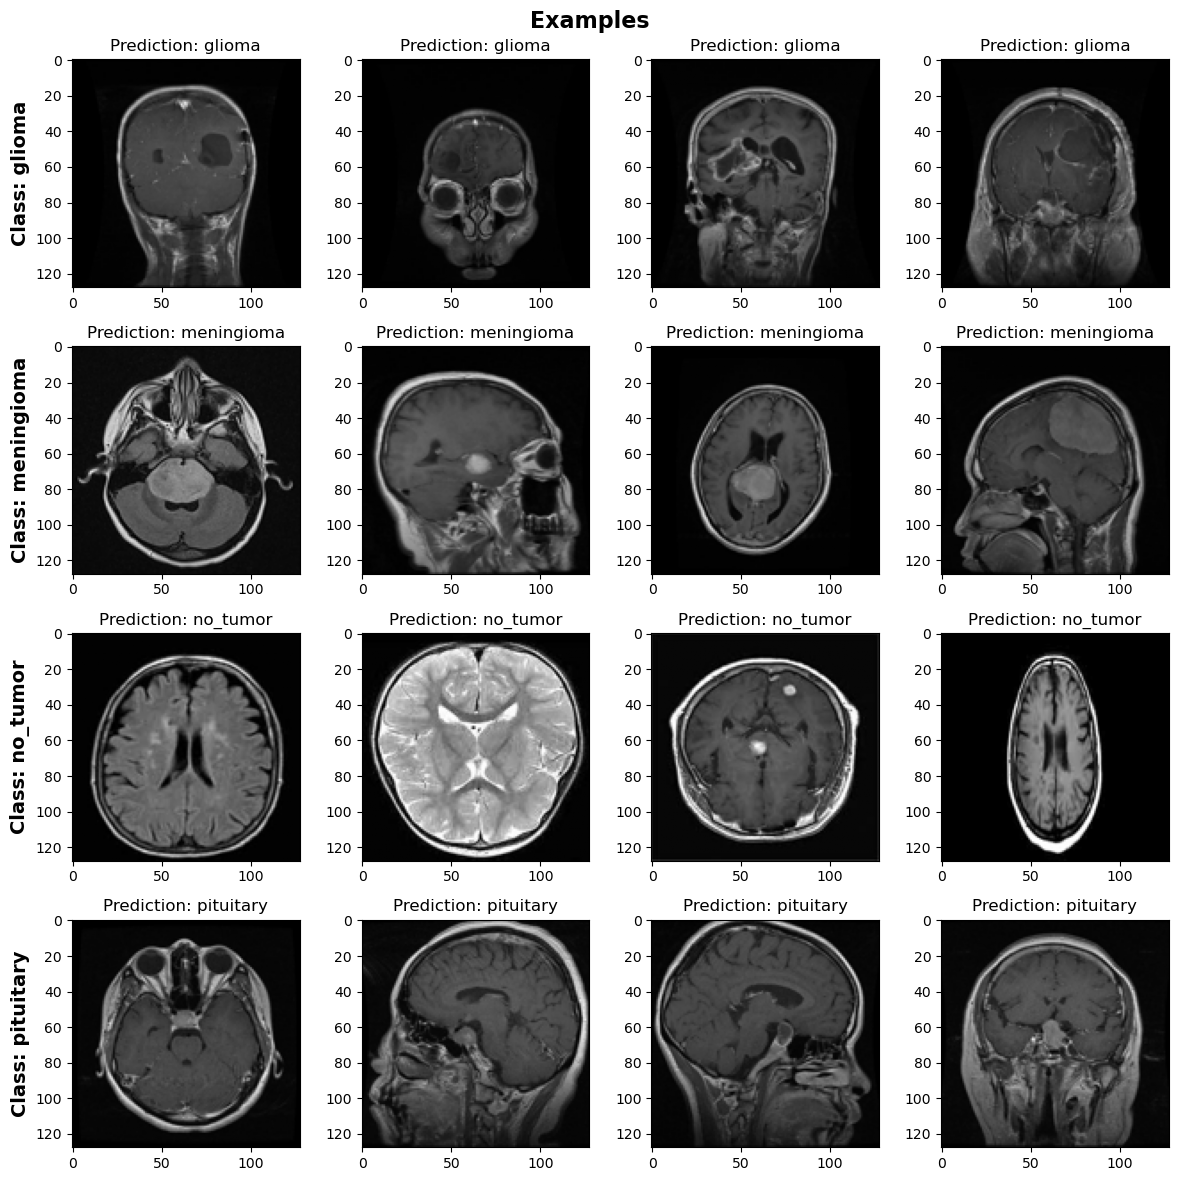

In [27]:
# Now that we have two ways of looking at location importance, lets just plot the images themselves for reference.
import matplotlib.pyplot as plt

# Select 4 instances of each class for explanation
instances_per_class = 4
instances_to_explain = []
for i in range(4):
    instances_to_explain.extend(np.where(y_test == i)[0][:instances_per_class])

# Create a single figure with multiple subplots
fig, axes = plt.subplots(4, instances_per_class, figsize=(12, 12), facecolor='white')

# Iterate over instances to explain and generate explanations
for i, instance_idx in enumerate(instances_to_explain):
    # Get image and label
    image = X_test[instance_idx]
    label = y_test[instance_idx]
    
    # Get the class name
    class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][int(label)]
    prediction = model.predict(image.reshape(1, 128, 128, 3))
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    predicted_class_name = ['glioma', 'meningioma', 'no_tumor', 'pituitary'][predicted_class]
    
    # Display the explanation on a subplot
    ax = axes[int(label), i % instances_per_class]
    ax.imshow(image)
    ax.set_title(f'Prediction: {predicted_class_name}')
    
    # Add superior title for each row indicating the class name
    if i % instances_per_class == 0:
        ax_row = axes[int(label), i % instances_per_class]
        ax_row.set_ylabel(f'Class: {class_name}', loc='center', fontsize=14, fontweight='bold')

# Adjust layout and show the figure
fig.suptitle('Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()